In [1]:
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from collections import Counter
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [2]:
def metric_calculation(pred, gt):    
    acc=accuracy_score(gt, pred)
    f1=f1_score(gt, pred, average='macro')
    confusion=confusion_matrix(gt, pred)
    fpr=confusion[0,1]/len(gt) ## predict to be 1; actual 0
    fnr=confusion[1,0]/len(gt) ## predict to be 0; actual 1
    return acc, f1, fpr, fnr

In [3]:
def post_processing(pred):
    new_pred=[]
    for i in pred:
        i=i.lower()
        if 'response' in i:
            try: new_pred.append(i.split('response')[1].split()[1].replace('</s>', ''))
            except: new_pred.append(2)
        elif 'output' in i:
            try: new_pred.append(i.split('output')[1].split()[1].replace('</s>', ''))
            except: new_pred.append(2)
        else:
            try: new_pred.append(i.split()[0].replace('</s>', ''))
            except:new_pred.append(2)
    new_pred = np.array([int(float(i)) if i in ['0', '0.0', '1', '1.0'] else 2 for i in new_pred])
    return new_pred

### average

In [4]:
ds = load_dataset("beanham/spatial_union_dataset")
test=ds['test']
gt=np.array(test['label'])

In [5]:
avg_values=np.array([
    [0.436,0.366,0.454,0.799,0.817,0.918],
    [0.509,0.558,0.494,0.792,0.695,0.918],
    [0.579,0.617,0.773,0.870,0.885,0.918],
    [0.414,0.361,0.521,0.835,0.802,0.918],
    [0.382,0.403,0.613,0.804,0.790,0.918],
    [0.471,0.681,0.819,0.902,0.864,0.918]])
avg_values=pd.DataFrame(avg_values, columns=['llama3', 'mistral', '4o-\nmini', 'qwen-\nplus', '4o', 'avg.\nheuristics'])
avg_values.index=['zero-shot\n(plain)', 'zero-shot\n(hints)', 'zero-shot\n(features)',
                  'few-shot\n(plain)', 'few-shot\n(hints)', 'few-shot\n(features)']

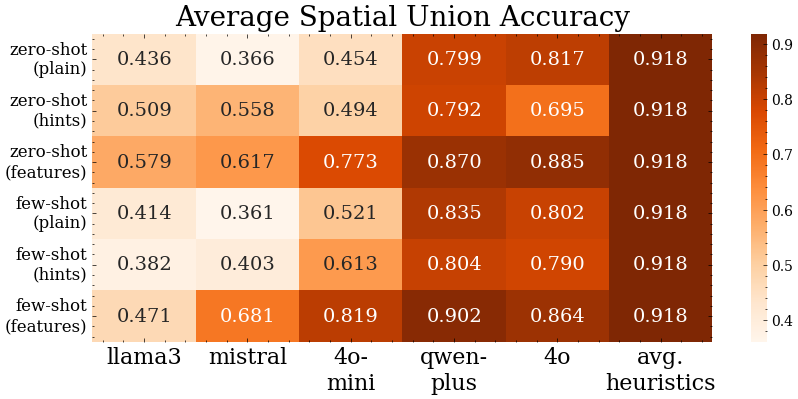

In [9]:
plt.style.use('science')
plt.rc('text', usetex=False)
plt.figure(figsize=(10,4))
ax=sns.heatmap(avg_values, annot=True, fmt = '.3f', cmap='Oranges', annot_kws={"fontsize":14})
ax.set_title('Average Spatial Union Accuracy',fontsize=20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=16)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)
plt.savefig(f'../../visualizations/union_task_average.png', bbox_inches='tight',pad_inches=0, dpi=600)
pass

### with features

In [9]:
configs = [
    'zero_shot_with_heur_value_angle',
    'zero_shot_with_heur_value_area',
    'zero_shot_with_heur_value_angle_area',
    'few_shot_with_heur_value_angle',
    'few_shot_with_heur_value_area',
    'few_shot_with_heur_value_angle_area',
]
new_names={
    'zero_shot_with_heur_value_angle': '(p)',
    'zero_shot_with_heur_value_area': '(o)',
    'zero_shot_with_heur_value_angle_area': '(p,o)',
    'few_shot_with_heur_value_angle': '(p)',
    'few_shot_with_heur_value_area': '(o)',
    'few_shot_with_heur_value_angle_area': '(p,o)'    
}

In [10]:
results=[]
models=['llama3', 'mistral', '4o_mini', 'qwen_plus', '4o']
for model in models:
    print(f'Model: {model}...')
    for config in configs:
        pred=np.load(f'base/{model}/{model}_{config}.npy')
        pred=post_processing(pred)        
        metrics=metric_calculation(pred, gt)
        if 'zero_shot' in config:
            prompting='zero shot'
        else:
            prompting='few shot'
        results.append([new_names[config], prompting, model, metrics[0], metrics[1]])
results=pd.DataFrame(results, columns=['heuristics', 'prompting', 'model', 'acc', 'f1'])

Model: llama3...
Model: mistral...
Model: 4o_mini...
Model: qwen_plus...
Model: 4o...


In [11]:
pals=sns.color_palette("RdBu", 12)
for model in models:
    sub=results[results.model==model]
    if model == 'llama3':
        plt.style.use('science')
        plt.rc('text', usetex=False)
        plt.figure(figsize=(3,3))
        sns.barplot(sub, x="heuristics", y="acc", hue="prompting", palette=[pals[4],pals[2]])
        plt.axhline(y=0.962, color='red', linestyle='-.', linewidth=2, label='Best Heuritic (0.962)')
        plt.xlabel("")
        plt.xticks(fontsize=12,rotation=90,ha='right')
        plt.ylabel("Spatial Union Accuracy", fontsize=12)
        #plt.title(model, fontsize=14)
        plt.legend()
        plt.savefig(f'../../visualizations/union_task_with_heuristic_values_{model}.png', bbox_inches='tight',pad_inches=0, dpi=600)
        plt.close()
        pass
    elif model == '4o':
        plt.style.use('science')
        plt.rc('text', usetex=False)
        plt.figure(figsize=(3,3))
        g=sns.barplot(sub, x="heuristics", y="acc", hue="prompting", palette=[pals[4],pals[2]], legend=False)
        plt.axhline(y=0.962, color='red', linestyle='-.', linewidth=2, label='Best Heuritic (0.990)')
        plt.xlabel("")
        plt.xticks(fontsize=12,rotation=90,ha='right')
        plt.ylabel("")
        plt.yticks([])
        #plt.title(model, fontsize=14)
        plt.savefig(f'../../visualizations/union_task_with_heuristic_values_{model}.png', bbox_inches='tight',pad_inches=0, dpi=600)
        plt.close()
        pass
    else:
        plt.style.use('science')
        plt.rc('text', usetex=False)
        plt.figure(figsize=(3,3))
        sns.barplot(sub, x="heuristics", y="acc", hue="prompting", palette=[pals[4],pals[2]], legend=False)
        plt.axhline(y=0.962, color='red', linestyle='-.', linewidth=2, label='Best Heuritic')
        plt.xlabel("")
        plt.xticks(fontsize=12,rotation=90,ha='right')
        plt.ylabel("")
        plt.yticks([])
        #plt.title(model, fontsize=14)
        plt.savefig(f'../../visualizations/union_task_with_heuristic_values_{model}.png', bbox_inches='tight',pad_inches=0, dpi=600)
        plt.close()
        pass        

### review-and-refine

In [6]:
avg_values=np.array([
    [0.509, 0.363, 0.521, 0.657, 0.877, 0.920, 0.920],
    [0.842, 0.366, 0.717, 0.867, 0.877, 0.920, 0.897],
    [0.870, 0.363, 0.702, 0.857, 0.925, 0.950, 0.947],
    [0.927, 0.363, 0.709, 0.900, 0.945, 0.955, 0.935],
    [0.962, 0.366, 0.739, 0.907, 0.957, 0.965, 0.942],
])
avg_values=pd.DataFrame(avg_values, columns=['init. acc', '4o-mini\n(hint)', 'qwen-plus\n(hint)', '4o\n(hint)', 
                                             '4o-mini\n(features)', 'qwen-plus\n(features)', '4o\n(features)'])
avg_values.index=['random', 'worst\nsingle', 'worst\nduo','best\nsingle', 'best\nduo']

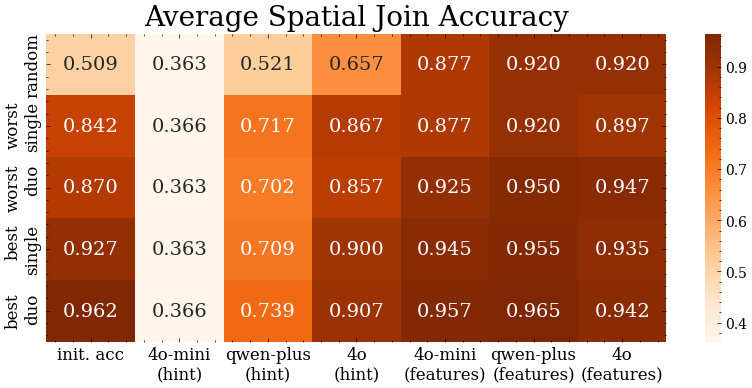

In [9]:
plt.style.use('science')
plt.rc('text', usetex=False)
plt.figure(figsize=(10,4))
ax=sns.heatmap(avg_values, annot=True, fmt = '.3f', cmap='Oranges', annot_kws={"fontsize":14})
ax.set_title('Average Spatial Join Accuracy',fontsize=20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)
plt.savefig(f'../../visualizations/union_task_review_and_refine.png', bbox_inches='tight',pad_inches=0, dpi=600)
pass

## Appendix

In [ ]:
pals=sns.color_palette("RdBu", 12)
for model in models:
    sub=results[results.model==model]
    if model == 'llama3':
        plt.style.use('science')
        plt.rc('text', usetex=False)
        plt.figure(figsize=(3,3))
        sns.barplot(sub, x="heuristics", y="acc", hue="prompting", palette=[pals[4],pals[2]], legend=False)
        plt.axhline(y=0.962, color='red', linestyle='-.', linewidth=2, label='Best Heuritic')
        plt.xlabel("")
        plt.xticks(fontsize=12,rotation=90,ha='right')
        plt.ylabel("Spatial Union Accuracy", fontsize=12)
        #plt.title(model, fontsize=14)
        plt.savefig(f'../../visualizations/union_task_no_heuristic_values_{model}.png', bbox_inches='tight',pad_inches=0, dpi=600)
        plt.close()
        pass
    elif model == '4o':
        plt.style.use('science')
        plt.rc('text', usetex=False)
        plt.figure(figsize=(3,3))
        g=sns.barplot(sub, x="heuristics", y="acc", hue="prompting", palette=[pals[4],pals[2]], legend=False)
        plt.axhline(y=0.962, color='red', linestyle='-.', linewidth=2, label='Best Heuritic (0.962)')
        plt.xlabel("")
        plt.xticks(fontsize=12,rotation=90,ha='right')
        plt.ylabel("")
        plt.yticks([])
        #plt.title(model, fontsize=14)
        plt.legend()
        plt.savefig(f'../../visualizations/union_task_no_heuristic_values_{model}.png', bbox_inches='tight',pad_inches=0, dpi=600)
        plt.close()
        pass        
    else:
        plt.style.use('science')
        plt.rc('text', usetex=False)
        plt.figure(figsize=(3,3))
        sns.barplot(sub, x="heuristics", y="acc", hue="prompting", palette=[pals[4],pals[2]], legend=False)
        plt.axhline(y=0.962, color='red', linestyle='-.', linewidth=2, label='Best Heuritic')
        plt.xlabel("")
        plt.xticks(fontsize=12,rotation=90,ha='right')
        plt.ylabel("")
        plt.yticks([])
        #plt.title(model, fontsize=14)
        plt.savefig(f'../../visualizations/union_task_no_heuristic_values_{model}.png', bbox_inches='tight',pad_inches=0, dpi=600)
        plt.close()
        pass        